In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import ta

In [20]:

# Load cleaned data
df = pd.read_csv('../data/processed/tesla_stock_cleaned.csv', parse_dates=['Date'], index_col='Date')

In [21]:
# Fix column names if needed
df.rename(columns={
    'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'
}, inplace=True)

In [22]:
df_feat = df.copy()
# Lag features
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)
df['lag_3'] = df['Close'].shift(3)

In [23]:
# Moving averages
df['sma_10'] = df['Close'].rolling(window=10).mean()


In [24]:
# Daily return
df['daily_return'] = df['Close'].pct_change()

In [25]:
# Add only key indicators
df['rsi'] = ta.momentum.RSIIndicator(close=df['Close'], window=14, fillna=True).rsi()
df['macd'] = ta.trend.MACD(close=df['Close'], fillna=True).macd()
df['bb_mean'] = ta.volatility.BollingerBands(close=df['Close'], fillna=True).bollinger_mavg()

In [26]:
# Temporal feature
df['day_of_week'] = df.index.dayofweek

In [27]:
# Drop rows with NaNs
df.dropna(inplace=True)

In [28]:
# 🧾 Save final dataset with features for Streamlit app
df[['lag_1', 'lag_2', 'lag_3', 'sma_10', 'daily_return']].to_csv('../data/processed/tesla_processed.csv', index=False)


In [29]:
# Feature set
features = ['lag_1', 'lag_2', 'lag_3', 'sma_10', 'daily_return']
#features = ['lag_1', 'lag_2', 'lag_3', 'sma_10', 'daily_return', 'rsi', 'macd', 'bb_mean', 'day_of_week']
target = 'Close'

X = df[features]
y = df[target]

In [30]:
# Train-test split
split = int(len(df) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [31]:
# Prediction
y_pred = model.predict(X_test)

In [32]:
# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [33]:
print(f" RMSE: {rmse:.2f}")
print(f" R² Score: {r2:.4f}")

 RMSE: 26.36
 R² Score: 0.8136


In [34]:
# 📏 Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [51]:
print(f" RMSE: {rmse:.2f}")
print(f" R² Score: {r2:.4f}")

 RMSE: 26.36
 R² Score: 0.8136


C:\Users\palre\anaconda3\envs\trendsense-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


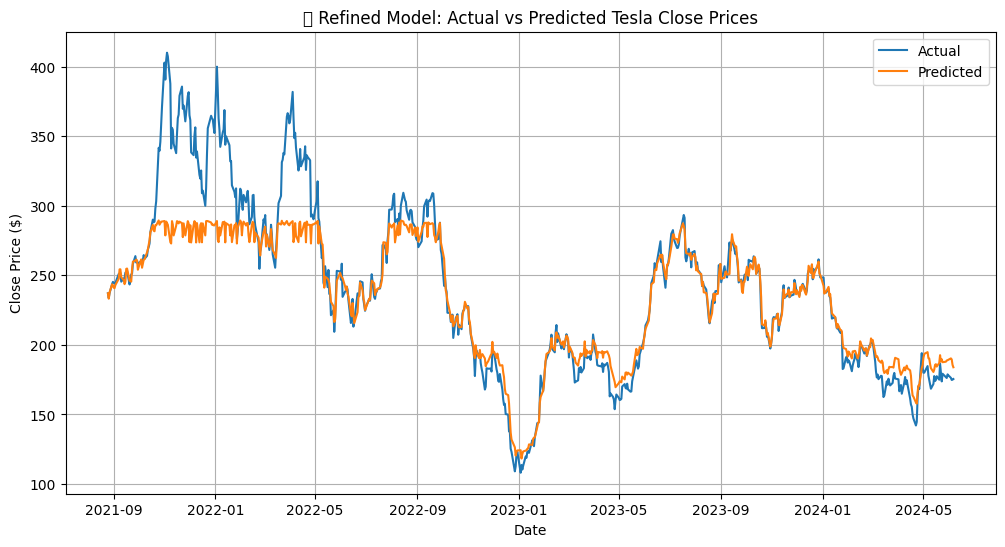

In [52]:
# Visualization
df_test = df.iloc[split:].copy()
df_test['Predicted_Close'] = y_pred

plt.figure(figsize=(12,6))
plt.plot(df_test.index, df_test['Close'], label='Actual')
plt.plot(df_test.index, df_test['Predicted_Close'], label='Predicted')
plt.title("📈 Refined Model: Actual vs Predicted Tesla Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [36]:
features = ['lag_1', 'lag_2', 'lag_3', 'sma_10', 'daily_return']
target = 'Close'

X = df[features]
y = df[target]

split = int(len(df) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"📉 Linear Regression - RMSE: {rmse_lr:.2f}, R²: {r2_lr:.4f}")


📉 Linear Regression - RMSE: 7.88, R²: 0.9833


In [38]:
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"🌿 Gradient Boosting - RMSE: {rmse_gbr:.2f}, R²: {r2_gbr:.4f}")


🌿 Gradient Boosting - RMSE: 25.08, R²: 0.8313


C:\Users\palre\anaconda3\envs\trendsense-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


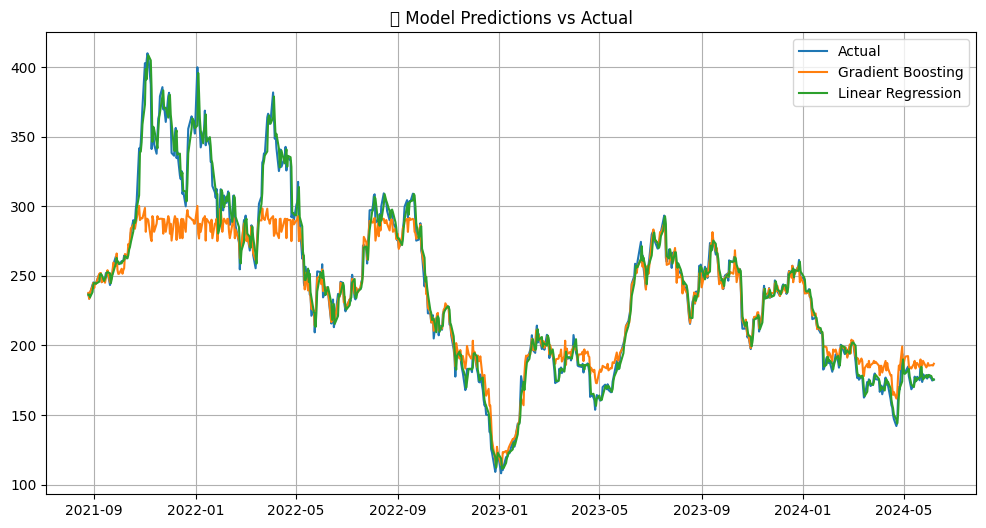

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual')
#plt.plot(y_test.index, y_pred_xgb, label='XGBoost')
plt.plot(y_test.index, y_pred_gbr, label='Gradient Boosting')
plt.plot(y_test.index, y_pred_lr, label='Linear Regression')
plt.title("📈 Model Predictions vs Actual")
plt.legend()
plt.grid(True)
plt.show()


In [40]:
import joblib

# Save model
joblib.dump(lr, '../models/linear_model.pkl')

# (Optional) Save the feature list too
joblib.dump(features, '../models/features_list.pkl')


['../models/features_list.pkl']

In [41]:
# Load model and features
loaded_model = joblib.load('../models/linear_model.pkl')
loaded_features = joblib.load('../models/features_list.pkl')

# Predict again using loaded model
sample = X_test.iloc[-1:].copy()  # most recent row
prediction = loaded_model.predict(sample)[0]

print(f"Predicted Close Price: ${prediction:.2f}")


Predicted Close Price: $175.41


In [42]:
df_test = df.iloc[split:].copy()
df_test['Predicted_Close'] = model.predict(X_test)
df_test.to_csv('../data/processed/predictions.csv')
